<a href="https://colab.research.google.com/github/profsuccodifrutta/Variational_Autoencoder_for_Anomaly_Detection/blob/main/final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Overview: Brain Tumor Detection using Variational Autoencoders (VAE)**



OBJECTIVE: The primary goal of this project is to develop an unsupervised learning
framework for the identification of brain tumors in MRI scans. By leveraging the principles of anomaly detection, the system aims to distinguish between healthy brain tissue and pathological structures without requiring extensive labeled datasets of various tumor types.

METHODOLOGY: Variational Autoencoders are generative models trained exclusively on images of healthy brain scans. The VAE learns to compress these images into a lower-dimensional latent space and then reconstruct them.



1.   Encoding: The model learns a distribution of features representing "normal" brain anatomy.

2.   Decoding: The model attempts to reconstruct the original image from this latent distribution.

In [12]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!mkdir -p /content/dataset_local
path_zip = "/content/drive/MyDrive/brainmri.zip"
!unzip -o -q "{path_zip}" -d /content/dataset_local

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score)

**Dataset Description**

For this project, has beed used the Brain Tumor MRI Dataset sourced from Kaggle. While this dataset is originally designed for multi-class classification (categorizing tumors into Glioma, Meningioma, Pituitary, or No Tumor), it can also be adapted  for unsupervised anomaly detection.

A custom BrainDataset class facilitates efficient data handling within the PyTorch framework. This class manages the loading of files and ensures consistency by converting images to grayscale ('L').

In [15]:
class BrainDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

The data pipeline involves splitting strategy to ensure model generalizability. Healthy images are partitioned using a 70/20/10 split, while all tumorous images are reserved strictly for the final testing phase.

* Training and Validation: Composed exclusively using images labeled as notumor (healthy scans).

*   Testing: The test set is composed of both healthy and non healthy images.

A fixed seed (42) is utilized during the random_split process to maintain reproducibility across different training runs.

In [16]:
file_sani = glob.glob("/content/dataset_local/**/Training/notumor/*.jpg", recursive=True)
print(f"Total healthy images: {len(file_sani)}")


full_healthy_ds = BrainDataset(file_sani)

train_size = int(0.7 * len(full_healthy_ds))
val_size = int(0.2 * len(full_healthy_ds))
test_size = len(full_healthy_ds) - train_size - val_size

train_subset, val_subset, test_healthy_subset = random_split(
    full_healthy_ds, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

file_anomalie = glob.glob("/content/dataset_local/**/Testing/*/*.jpg", recursive=True)
file_anomalie = [f for f in file_anomalie if "notumor" not in f]


test_anomaly_ds = BrainDataset(file_anomalie)

print(f"Training: {len(train_subset)} | Val: {len(val_subset)} | Test : {len(test_healthy_subset)}")
print(f"Anomalies for test: {len(file_anomalie)}")

Total healthy images: 1595
Training: 1116 | Val: 319 | Test : 160
Anomalies for test: 906


**Data Preprocessing and Augmentation**

All images are resized to 224x224 pixels. This ensures consistent input dimensions. Additionaly is applied a RandomHorizontalFlip with a probability of $p=0.5$. This technique artificially increases the dataset's diversity, helping the model become invariant to horizontal orientation and reducing the risk of overfitting. The ToTensor() operation scales the pixel intensity values from the range [0, 255] to a floating-point range of [0, 1].

In [17]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

**Batch Configuration and Data Loading**

The data is managed through PyTorch DataLoaders to optimize memory usage and computational efficiency. The train_loader uses shuffle=True. Shuffling at each epoch is critical to ensure the model does not learn the order of the training samples, promoting better generalization.

In [18]:
batch_size = 32

train_loader = DataLoader(
    BrainDataset([train_subset.dataset.file_list[i] for i in train_subset.indices], transform=train_transform),
    batch_size=batch_size, shuffle=True)

val_loader = DataLoader(
    BrainDataset([val_subset.dataset.file_list[i] for i in val_subset.indices], transform=base_transform),
    batch_size=batch_size, shuffle=False)

**Residual Block**

By utilizing the identity mapping principle introduced by He et al. (2016), the block allows the network to learn residual functions rather than direct mappings, which significantly eases the optimization process. The skip connection ($x + \text{conv}(x)$) ensures that the gradient can bypass the non-linear transformations, mitigating the vanishing gradient problem. This is crucial for ensuring that the initial layers of the encoder still receive strong signals during backpropagation.

The choice of LeakyReLU ($0.2$) is strategically superior to standard ReLU in this context. Radford et al. (2015) demonstrated in their work on DCGANs ("Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks") that LeakyReLU is superior for learning stable filters in the encoder sections of generative architectures. Additionally allowing a small negative slope prevents the "dying ReLU" problem.



In [19]:
class ResBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.relu(x + self.conv(x))

**Architecture**

The VAE architecture is designed as a symmetric bottleneck model. The Encoder utilizes a series of strided convolutions and Residual Blocks to compress the $224 \times 224$ input into a high-level feature map, which is then projected into a 2048-dimensional latent space. To ensure the network remains differentiable, the model implements the reparameterization trick: instead of sampling directly from the stochastic distribution, it computes a latent vector $z = \mu + \epsilon \odot \sigma$, where $\epsilon \sim \mathcal{N}(0, 1)$. This formulation allows the gradients to bypass the sampling process during backpropagation. The Decoder subsequently mirrors the encoder’s structure, using transposed convolutions to reconstruct the original image. By training exclusively on healthy samples, the model learns a constrained manifold of normal brain anatomy; consequently, any structural anomaly in the test data results in a high reconstruction error, which serves as a primary metric for anomaly detection.

In the encoder, the images pass through nine convolutional layers, including those within the Residual Blocks, to extract hierarchical features. Once the final feature map is reached, a flattening operation is applied, resulting in 12,544 neurons which are fully connected to a 4,096-neuron hidden layer. This representation is finally reduced to 2,048 latent dimensions. This intermediate layer was added to provide gradual dimensionality reduction, ensuring that complex spatial information is distilled effectively without significant data loss before reaching the stochastic bottleneck.

In [24]:
class VAE_V6(nn.Module):
    def __init__(self, latent_dim=2048):
        super(VAE_V6, self).__init__()

        # ENCODER: 224 -> 112 -> 56 -> 28 -> 14 -> 7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            ResBlock(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            ResBlock(128),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2)
        )

        self.flatten_dim = 256 * 7 * 7

        self.fc_hidden_enc = nn.Sequential(
            nn.Linear(self.flatten_dim, 4096),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        )
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)

        self.decoder_input = nn.Sequential(
            nn.Linear(latent_dim, 4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, self.flatten_dim),
            nn.LeakyReLU(0.2)
        )
        self.unflatten = nn.Unflatten(1, (256, 7, 7))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            ResBlock(128),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            ResBlock(64),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            if m.out_channels == 1:
                nn.init.xavier_normal_(m.weight)
            else:
                nn.init.kaiming_normal_(m.weight, a=0.2, mode='fan_out', nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        h = torch.flatten(h, start_dim=1)
        hidden = self.fc_hidden_enc(h)
        mu, logvar = self.fc_mu(hidden), self.fc_logvar(hidden)

        # Clamp per stabilità numerica
        logvar = torch.clamp(logvar, -10, 10)

        z = self.reparameterize(mu, logvar)
        dec_hid = self.decoder_input(z)
        x_recon = self.decoder(self.unflatten(dec_hid))
        return x_recon, mu, logvar

**Loss Function**

To optimize the training of the VAE, a composite loss function was implemented, combining pixel-wise accuracy, structural fidelity, and latent space regularization. The total loss is defined as:$$\mathcal{L}_{Total} = \mathcal{L}_{MaskedBCE} + 5 \cdot \mathcal{L}_{SSIM} + \beta \cdot \mathcal{L}_{KLD}$$


Masked Binary Cross-Entropy ($\mathcal{L}_{MaskedBCE}$): To prevent the model from overfitting to the uninformative black background of the brain scans, a intensity-based mask ($x > 0.05$) was applied. This ensures the reconstruction loss focuses exclusively on the anatomical structures.


Structural Similarity Index ($\mathcal{L}_{SSIM}$): SSIM evaluates the preservation of luminance, contrast, and structure. In medical imaging, maintaining structural integrity is vital, the SSIM component compels the model to reconstruct sharp edges and consistent tissue textures, which are often blurred by standard MSE or BCE losses.
The ssim_loss function is derived from the SSIM index, which compares two images ($x$ and $y$) based on three distinct components: luminance ($l$), contrast ($c$), and structure ($s$). Mathematically, the index is calculated within a local window (in this case, an $11 \times 11$ area) using the formula:

$$SSIM(x, y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$$

Where: $\mu_x, \mu_y$ are the local means (luminance), $\sigma_x^2, \sigma_y^2$ are the local variances (contrast), $\sigma_{xy}$ is the local covariance (structural correlation), $C_1, C_2$ are constants ($0.01^2$ and $0.03^2$) to stabilize the division when the denominator is close to zero.
Since the goal is to minimize the difference between images, the loss is defined as $\mathcal{L}_{SSIM} = 1 - SSIM$. This forces the VAE to reconstruct not just the correct pixel intensities, but the specific spatial patterns and textures of the brain tissue.
The total loss utilizes a multiplier of 5 for the SSIM component. This coefficient was determined through manual tuning to achieve a magnitude balance between the Masked BCE and SSIM losses.

During training, pixel-wise losses (BCE) often yield different numerical scales than structural losses (SSIM). Without this scaling factor, the optimizer might prioritize intensity matching while neglecting structural sharpness, or vice versa. By applying the weight, both terms contribute with similar "intensity" to the total gradient, ensuring the model simultaneously learns global anatomical brightness and fine-grained structural detail.

Kullback-Leibler Divergence ($\mathcal{L}_{KLD}$): This term regularizes the latent space, forcing the encoded distributions to approximate a standard normal distribution $\mathcal{N}(0, I)$. To avoid the common issue of posterior collapse—where the KL divergence drops to zero and the model ignores the latent variables—a linear warmup (or annealing) strategy is implemented for the $\beta$ coefficient. The value of $\beta$ at any given epoch $t$ is defined by:$$\beta(t) = \min\left(\beta_{target}, \beta_{target} \cdot \frac{t}{T_{warmup}}\right)$$

In [21]:
def ssim_loss(img1, img2, window_size=11):
    mu1 = F.avg_pool2d(img1, window_size, stride=1, padding=window_size//2)
    mu2 = F.avg_pool2d(img2, window_size, stride=1, padding=window_size//2)

    sigma1_sq = F.avg_pool2d(img1 * img1, window_size, stride=1, padding=window_size//2) - mu1.pow(2)
    sigma2_sq = F.avg_pool2d(img2 * img2, window_size, stride=1, padding=window_size//2) - mu2.pow(2)

    sigma1_sq = torch.clamp(sigma1_sq, min=0)
    sigma2_sq = torch.clamp(sigma2_sq, min=0)

    sigma12 = F.avg_pool2d(img1 * img2, window_size, stride=1, padding=window_size//2) - (mu1 * mu2)

    c1, c2 = 0.01**2, 0.03**2

    num = (2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)
    den = (mu1.pow(2) + mu2.pow(2) + c1) * (sigma1_sq + sigma2_sq + c2)

    return 1 - (num / (den + 1e-7)).mean()

def loss_function(recon_x, x, mu, logvar, beta=0.005):
    mask = (x > 0.05).float()
    recon_x = torch.clamp(recon_x, min=1e-7, max=1-1e-7)
    bce_per_pixel = F.binary_cross_entropy(recon_x, x, reduction='none')
    masked_bce = (bce_per_pixel * mask).sum() / (mask.sum() + 1e-8)
    ssim = ssim_loss(recon_x, x)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = masked_bce + (5 * ssim) + (beta * kl)
    return total_loss, masked_bce, kl

**Optimizer and Learning rate**

While the standard Adam optimizer is a common choice, AdamW (Adam with Decoupled Weight Decay) was selected for its superior handling of regularization. In traditional Adam, $L_2$ regularization is blended with the gradient updates. In AdamW, the weight decay is applied directly to the weights, separated from the adaptive gradient calculation. This leads to better generalization, which is critical in medical imaging.
The choice of the AdamW optimizer is further supported by recent theoretical analyses (e.g., Zhou et al. (2024)) which prove that decoupled weight decay provides superior convergence and generalization compared to standard $\ell_2$-regularized Adam. This is particularly relevant for over-parametrized networks like the VAE, where the dense bottleneck layer contains over 51 million parameters.

The ReduceLROnPlateau scheduler monitors the Validation Loss. If the loss ceases to improve for a set number of epochs (patience=5), the scheduler automatically reduces the learning rate by a factor of 0.5.

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 2048
model = VAE_V6(latent_dim=latent_dim).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


The plot_reconstruction function serves as a qualitative monitoring tool during training. By plotting the original brain scan alongside its reconstruction every 5 epochs, we can observe the progression of the model's learning.

In [22]:
def plot_reconstruction(model, val_loader, device, epoch):
    model.eval()
    with torch.no_grad():
        # batch dal loader di validazione
        inputs = next(iter(val_loader))
        inputs = inputs.to(device)

        # Ricostruzione
        recons, mu, logvar = model(inputs)

        # su cpu per plottare
        img = inputs[0].cpu().squeeze().numpy()
        recon = recons[0].cpu().squeeze().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Originale")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(recon, cmap='gray')
        plt.title(f"Ricostruzione Epoca {epoch+1}")
        plt.axis('off')

        plt.show()

In [ ]:
import numpy as np

# training loop

def train_vae(model, train_loader, val_loader, optimizer, scheduler, num_epochs):
    train_history = {'total': [], 'recon': [], 'kl': []}
    val_history = {'total': [], 'recon': [], 'kl': []}

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()

        current_beta = min(target_beta, target_beta * (epoch / warmup_epochs))

        train_total, train_recon, train_kl = 0, 0, 0

        for batch in train_loader:
            batch = batch.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)

            loss, r_loss, k_loss = loss_function(recon_batch, batch, mu, logvar, beta=current_beta)

            if torch.isnan(loss):
                print(f" Batch saltato all'epoca {epoch+1}: rilevato NaN nella loss")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_total += loss.item()
            train_recon += r_loss.item()
            train_kl += k_loss.item()

        # VALIDATION
        model.eval()
        val_total, val_recon, val_kl = 0, 0, 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                recon_batch, mu, logvar = model(batch)
                loss, r_loss, k_loss = loss_function(recon_batch, batch, mu, logvar, beta=current_beta)

                val_total += loss.item()
                val_recon += r_loss.item()
                val_kl += k_loss.item()


        avg_train_loss = train_total / len(train_loader)
        avg_val_loss = val_total / len(val_loader)

        scheduler.step(avg_val_loss)

        train_history['total'].append(avg_train_loss)
        val_history['total'].append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Beta: {current_beta:.5f} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/VAE_Brain_Project/best_model_v6.pth')
            print(" Best model saved")


        if (epoch + 1) % 5 == 0:
            print(f"\n--- Visualizzazione Ricostruzione (Epoca {epoch+1}) ---")
            plot_reconstruction(model, val_loader, device, epoch)

            plt.figure(figsize=(8, 4))
            plt.plot(train_history['total'], label='Train Loss')
            plt.plot(val_history['total'], label='Val Loss')
            plt.title(f"Andamento Loss fino ad Epoca {epoch+1}")
            plt.legend()
            plt.show()

    return train_history, val_history

**Gradient Clipping**


The implementation of gradient clipping via torch.nn.utils.clip_grad_norm_ serves as a critical stabilization mechanism for the VAE training. Given the high capacity of the 51-million-parameter bottleneck and the sensitivity of the latent space's exponential terms ($e^{logvar}$), the model is susceptible to the exploding gradient problem. By capping the global $L_2$ norm of the gradients at 1.0, we ensure that the optimization steps remain within a stable range. This prevents numerical instability.

In [ ]:
# TRAINING
num_epochs = 80
target_beta = 0.005
warmup_epochs = 20

history_train, history_val = train_vae(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs
)

Since training was performed on a different hardware here are attached just some of the reconstruction obtained during traing, as well as the loss.

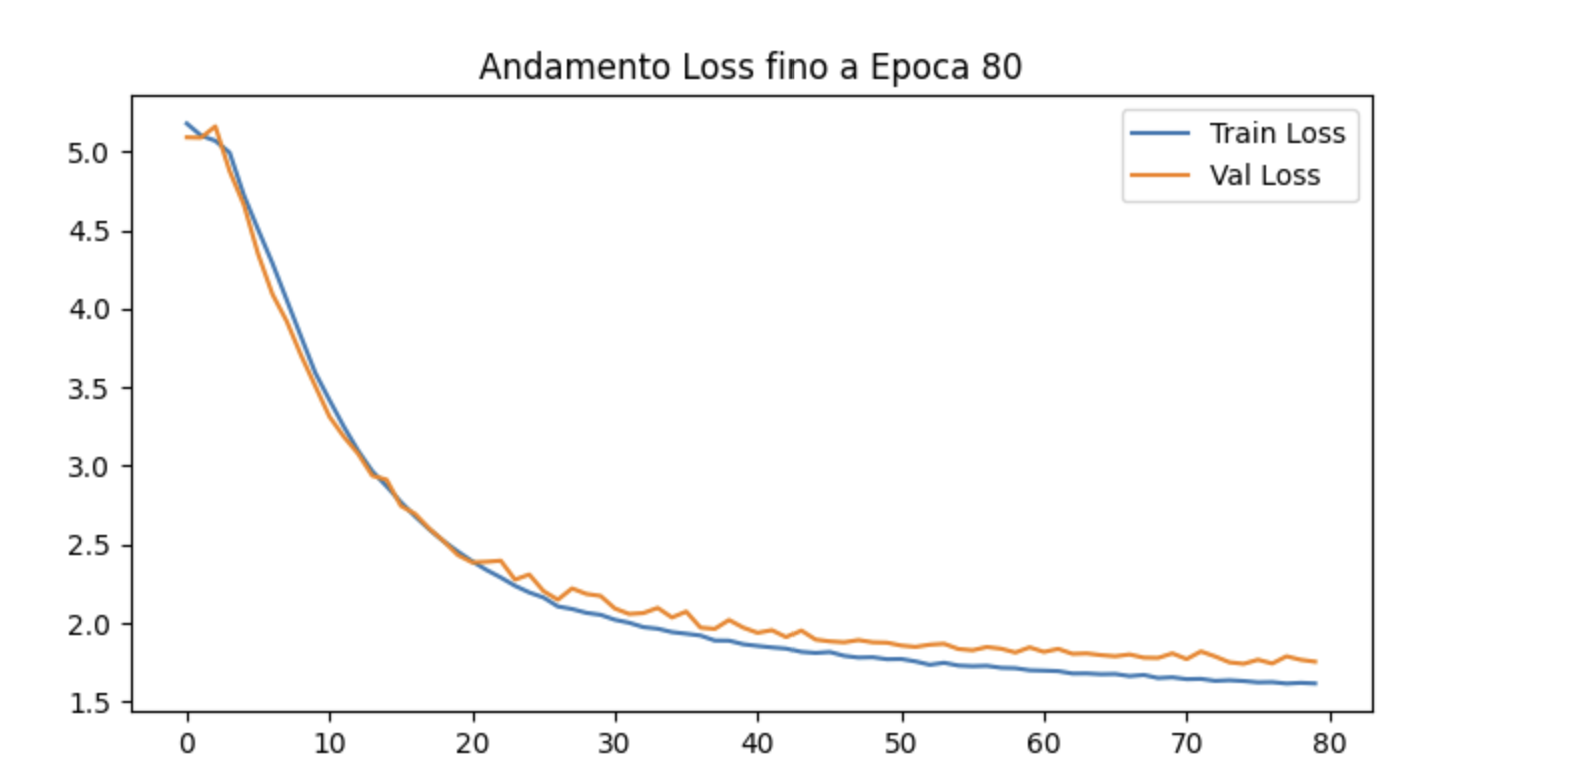

The loss profile confirms the effectiveness of the proposed training strategy. The initial rapid convergence followed by a stable plateau suggests that the model has effectively learned a robust manifold for healthy brain anatomy. The absence of divergence in the validation curve after the $\beta$-warmup phase (epoch 20) demonstrates that the chosen latent dimensionality and regularization parameters are well-balanced.

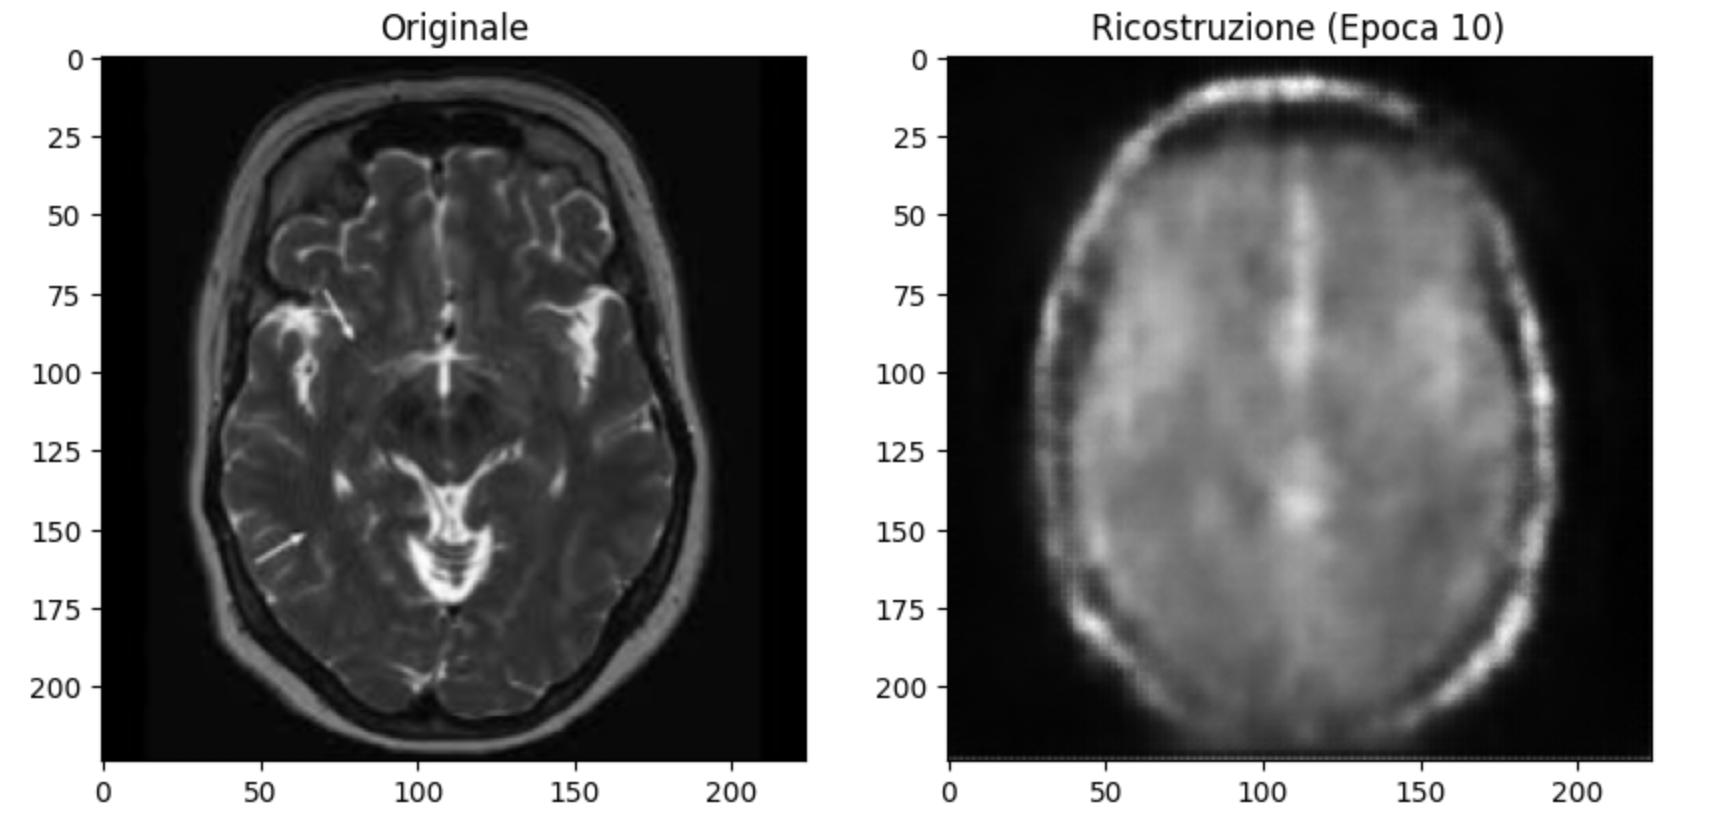

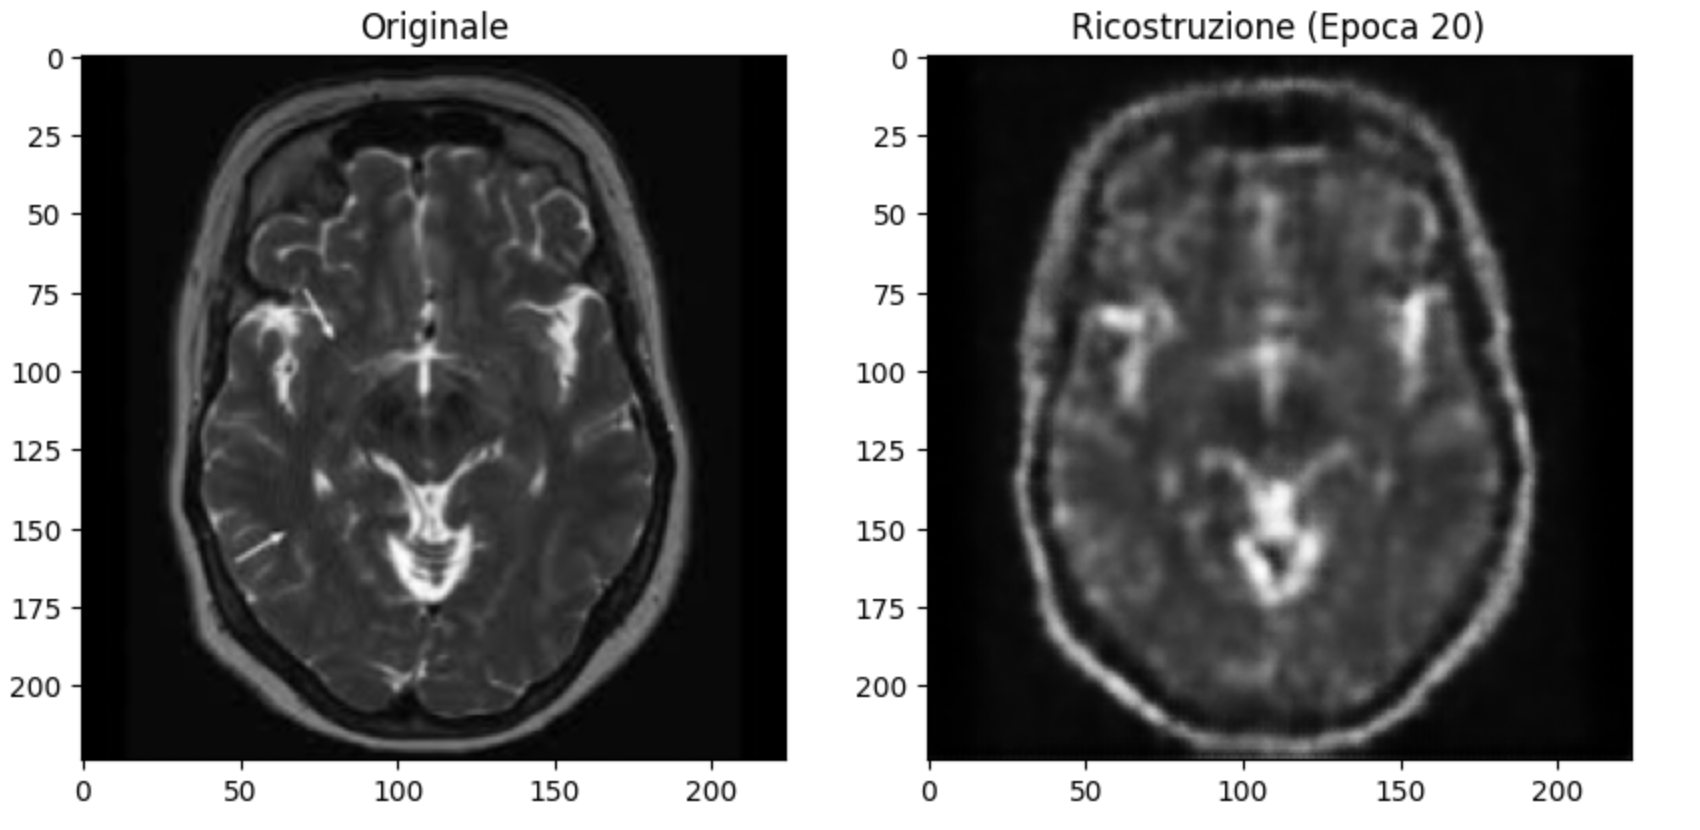

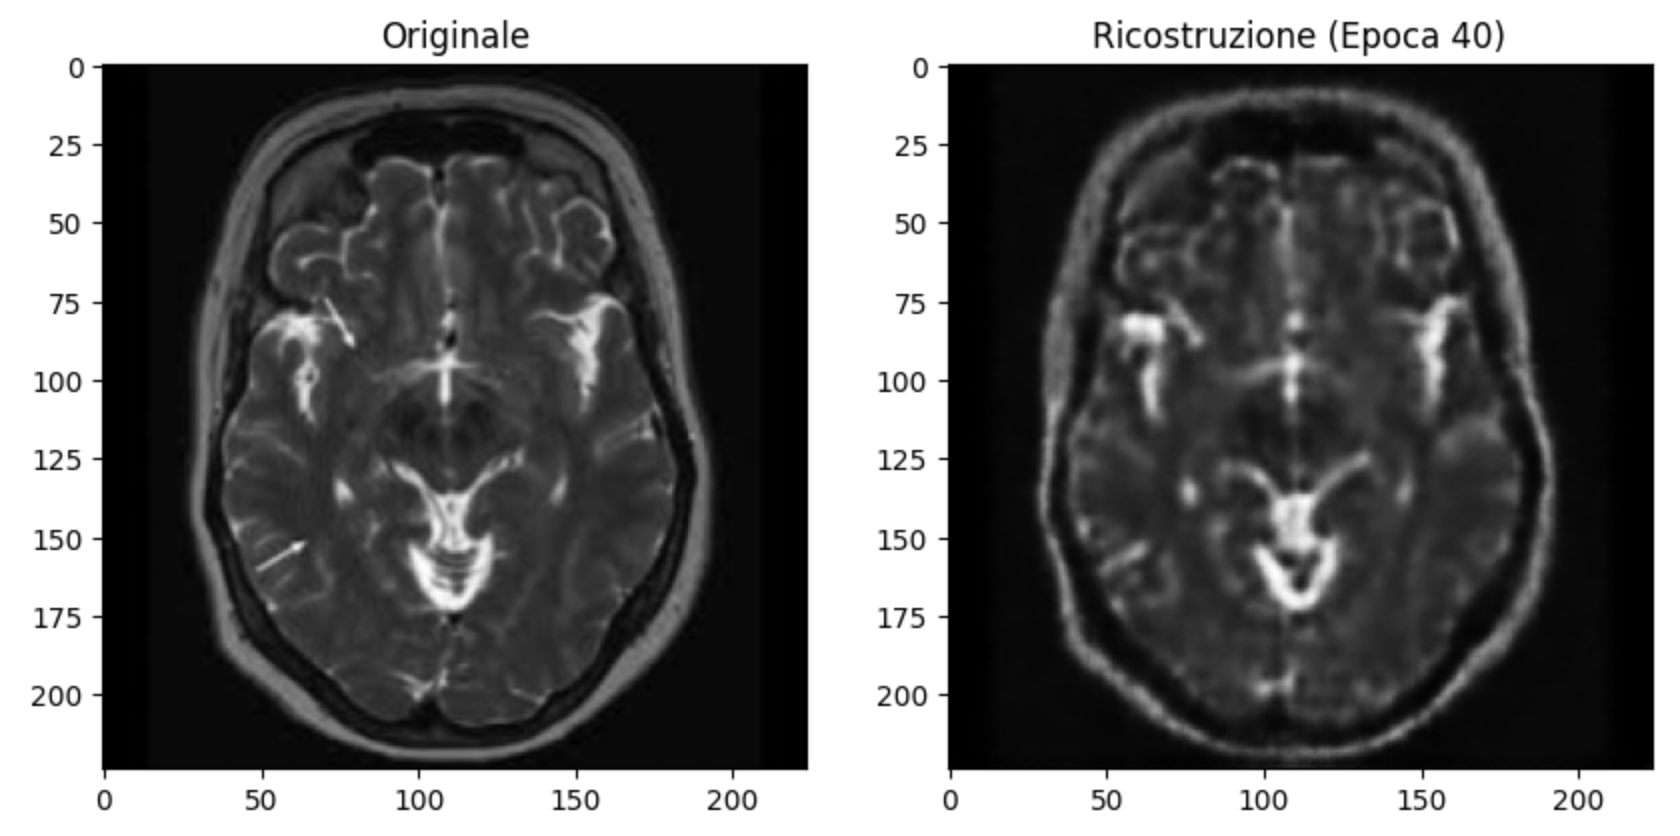

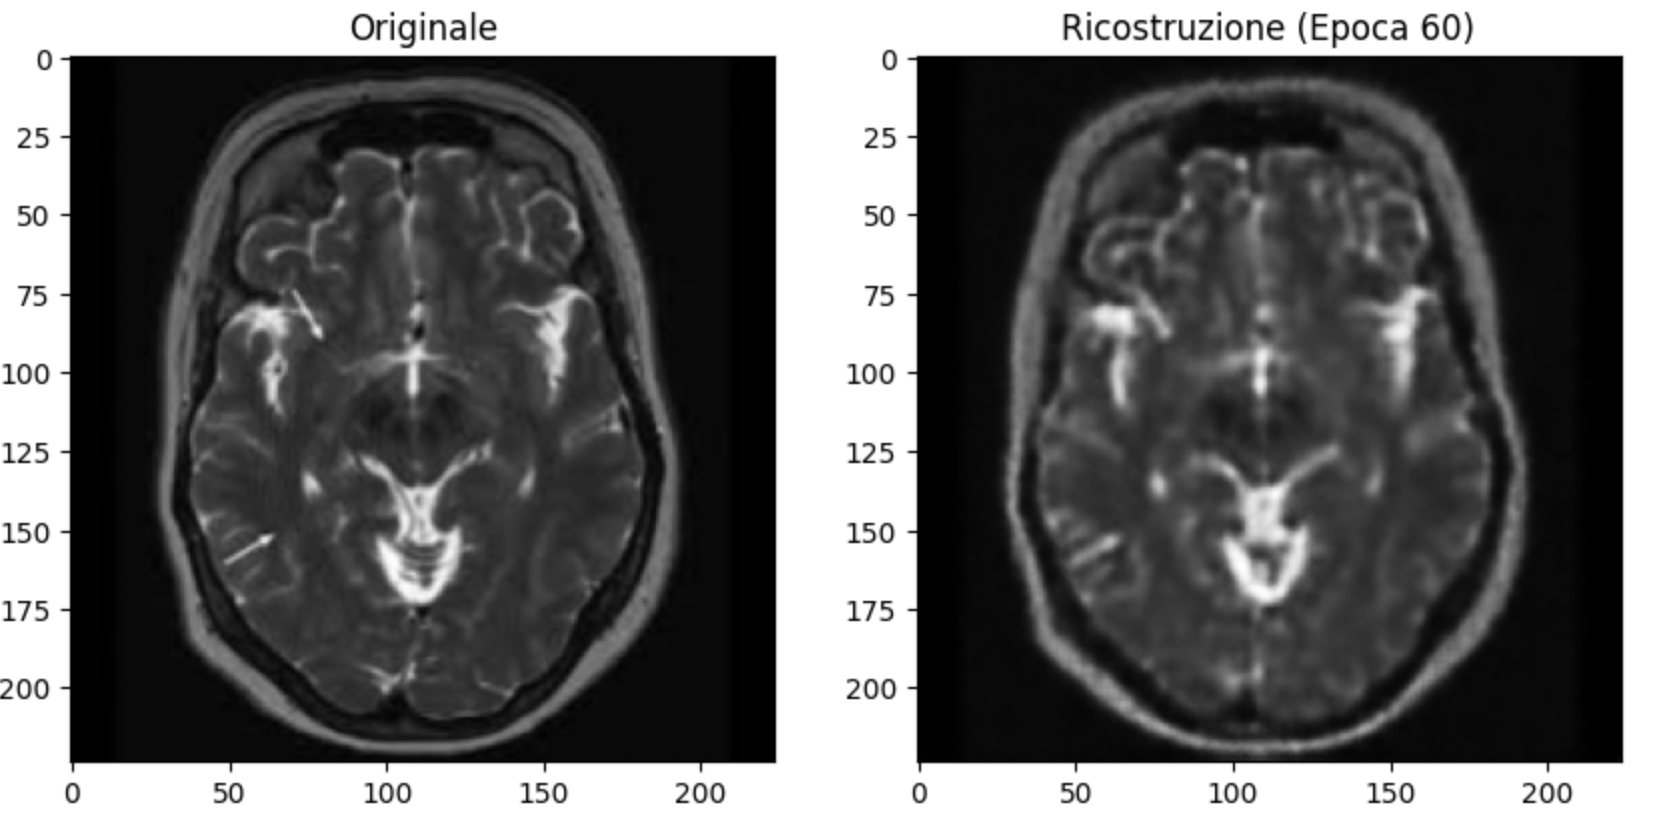

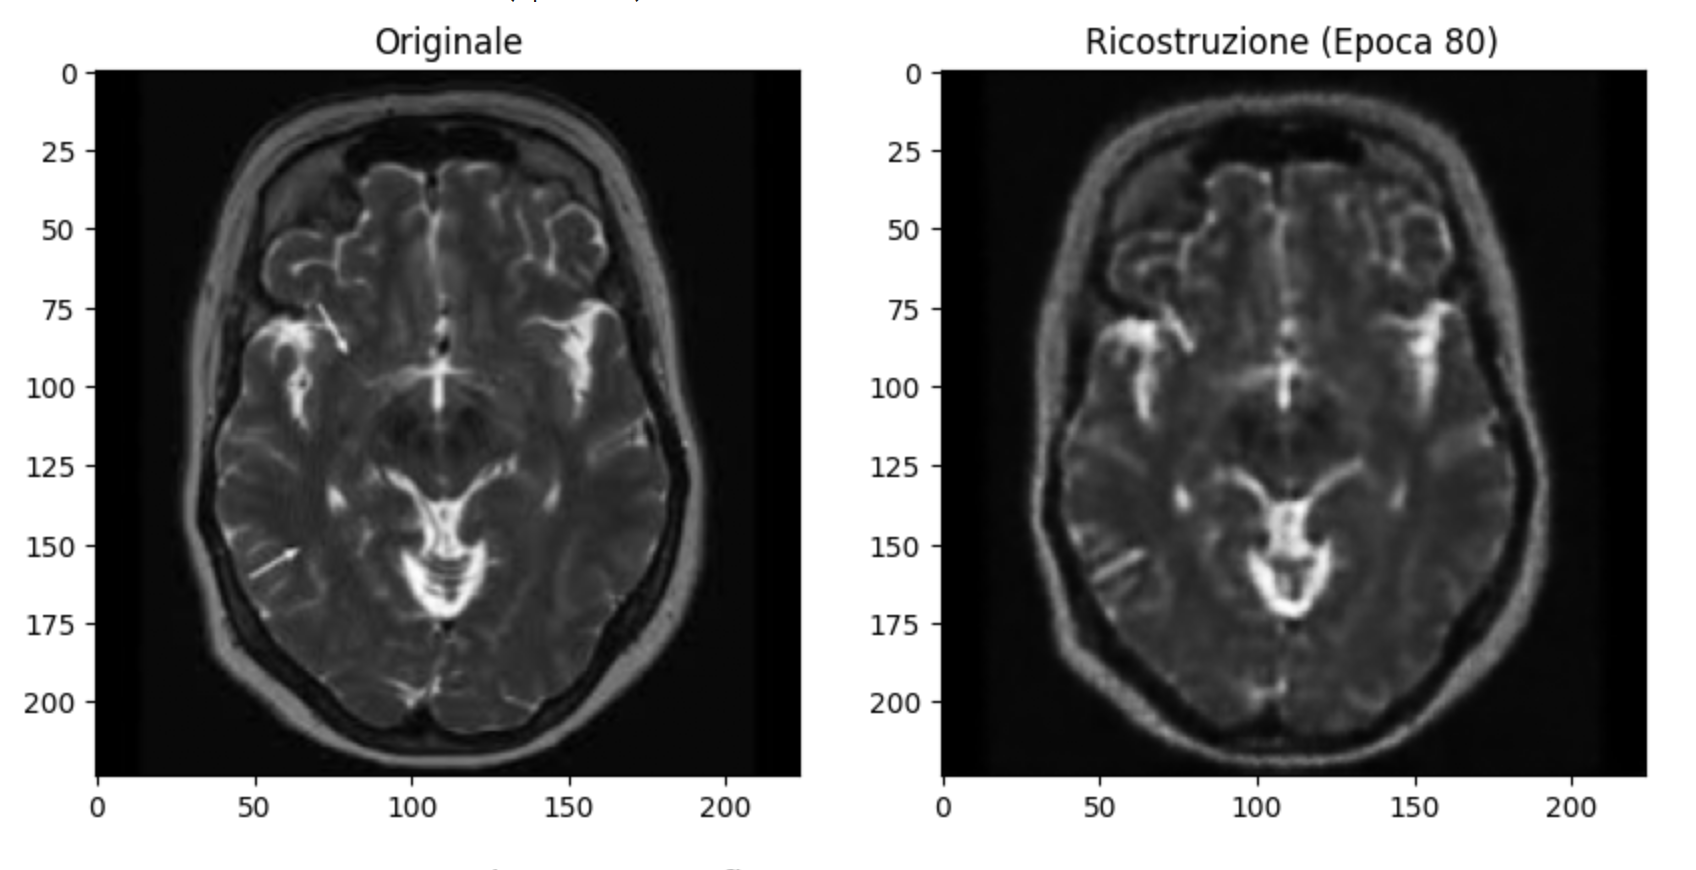

In [25]:
# loading the model
from google.colab import drive
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 2048
model = VAE_V6(latent_dim=latent_dim).to(device)

model_path_v6 = "/content/drive/MyDrive/VAE_Brain_Project/best_model_v6.pth"

try:
    checkpoint = torch.load(model_path_v6, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()
    print(f" Model V6 loaded")
    total_params = sum(p.numel() for p in model.parameters())
    print(f" # of parameters: {total_params:,} parameters.")


except FileNotFoundError:
    print(f" Errore: Il file '{model_path_v6}' non esiste.")

 Model V6 loaded
 # of parameters: 130,647,937 parameters.


**Classification Logic**

The classification logic relies on the assumption that the VAE  can only reconstruct healthy images. By computing the Masked Mean Squared Error at inference time, we generate a scalar anomaly score for each image. This score represents the average reconstruction failure per pixel within the brain mask. A high score indicates a significant structural deviation from the learned 'healthy manifold,' allowing for the identification of tumors and other pathologies through a simple thresholding mechanism.

Unlike the training phase which uses a composite BCE and SSIM loss, the inference stage utilizes MSE (reduction='none') to calculate the raw intensity difference between the original input ($x$) and the reconstruction ($\hat{x}$) for every individual pixel:$$e_{i,j} = (x_{i,j} - \hat{x}_{i,j})^2$$

To prevent the uninformative black background from diluting the results, a threshold mask is applied (images > 0.05). This ensures the scoring logic is strictly localized to the brain's anatomy.

In [28]:
def get_anomaly_scores(model, dataloader, device):
    model.eval()
    mse_loss = nn.MSELoss(reduction='none') # reduction none = doesnt aggragate and returns avg error per pixel

    anomaly_scores = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            recon, _, _ = model(images) # mu and logvar not needed
            error_per_pixel = mse_loss(recon, images)
            mask = (images > 0.05).float()
            masked_error = error_per_pixel * mask
            error_sum = masked_error.view(masked_error.size(0), -1).sum(dim=1)
            pixels_count = mask.view(mask.size(0), -1).sum(dim=1)
            batch_scores = error_sum / (pixels_count + 1e-8)
            anomaly_scores.extend(batch_scores.cpu().numpy())

    return anomaly_scores

**Ottimizzazione soglia**

The available pathological samples were partitioned using a $20/80$ split to separate threshold calibration from final performance testing. By combining the healthy validation scores with a subset of anomalous samples, we generated a mixed validation set used to calculate the ROC (Receiver Operating Characteristic) curve. The optimal classification threshold was then determined by identifying the point on the curve that maximizes the Youden’s J statistic ($TPR - FPR$), effectively balancing sensitivity and specificity. This rigorous approach ensures that the decision boundary is calibrated on validation data, leaving the larger test set as an entirely independent benchmark for the model's clinical accuracy. (NO DATA LEAKAGE)

In [30]:
file_anomalie_totali = glob.glob("/content/dataset_local/**/Testing/*/*.jpg", recursive=True)
file_anomalie_totali = [f for f in file_anomalie_totali if "notumor" not in f]

# - val_anomalie_files: for threhold calibration
# - test_anomalie_files: for final test
val_anomalie_files, test_anomalie_files = train_test_split(
    file_anomalie_totali, test_size=0.80, random_state=42
)

print(f"Tumors for Validation: {len(val_anomalie_files)}")
print(f"Tumors for final test: {len(test_anomalie_files)}")

#  Loader for calibration (healthy from Val + Tumors from Val)
val_sani_loader = DataLoader(
    BrainDataset([val_subset.dataset.file_list[i] for i in val_subset.indices], transform=base_transform),
    batch_size=batch_size, shuffle=False
)
val_anomalie_loader = DataLoader(
    BrainDataset(val_anomalie_files, transform=base_transform),
    batch_size=batch_size, shuffle=False
)

#  Loader for final test (healthy from Test + tumor from Test)
test_loader_sani = DataLoader(
    BrainDataset([test_healthy_subset.dataset.file_list[i] for i in test_healthy_subset.indices], transform=base_transform),
    batch_size=batch_size, shuffle=False
)
test_loader_anomalie = DataLoader(
    BrainDataset(test_anomalie_files, transform=base_transform),
    batch_size=batch_size, shuffle=False
)

val_sani_scores = get_anomaly_scores(model, val_sani_loader, device)
val_anno_scores = get_anomaly_scores(model, val_anomalie_loader, device)

# Label Validation (0=Sano, 1=Tumore) ---> [0, 0, ..., 1, 1, ...]
y_val_true = [0] * len(val_sani_scores) + [1] * len(val_anno_scores)
y_val_scores = val_sani_scores + val_anno_scores


fpr_val, tpr_val, thresholds_val = roc_curve(y_val_true, y_val_scores)
optimal_idx = np.argmax(tpr_val - fpr_val)
optimal_threshold = thresholds_val[optimal_idx]

print(f" Optimal threshold calibrated on mixed validation: {optimal_threshold:.6f}")


Tumors for Validation: 181
Tumors for final test: 725
 Optimal threshold calibrated on mixed validation: 0.009625


Test set size: 885


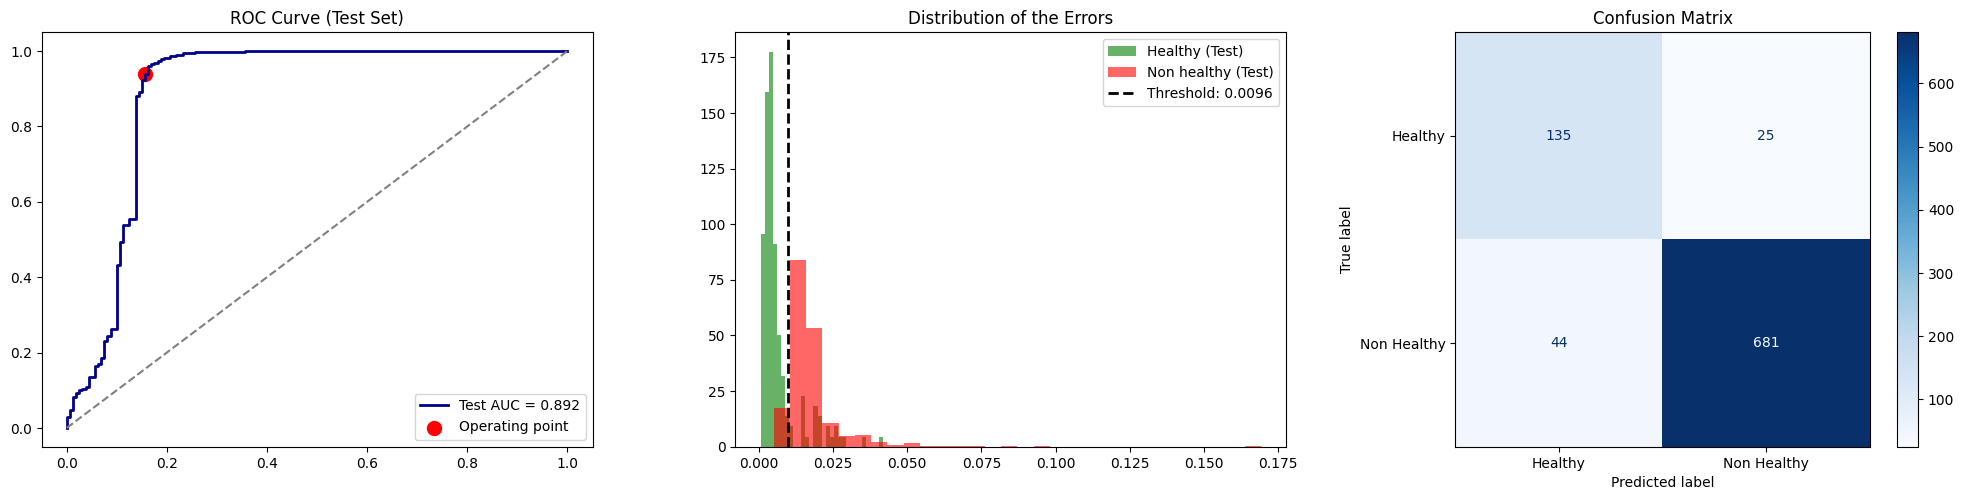


   Final Report 
Applied threshold:     0.009625
----------------------------------------
Accuracy:              0.9220
AUC Score:             0.8925
Recall (Sensitivity):  0.9393
Specificity:           0.8438
F1-Score:              0.9518
No Information Rate:   0.8192
----------------------------------------
              precision    recall  f1-score   support

     Healthy       0.75      0.84      0.80       160
 Non healthy       0.96      0.94      0.95       725

    accuracy                           0.92       885
   macro avg       0.86      0.89      0.87       885
weighted avg       0.93      0.92      0.92       885



In [31]:
# Calcolo Score Test
test_healthy_scores = get_anomaly_scores(model, test_loader_sani, device)
test_anomaly_scores = get_anomaly_scores(model, test_loader_anomalie, device)

# label for test (0 = Sano, 1 = Tumore) ---> [0, 0, ..., 1, 1, ...]
y_test_true = np.array([0] * len(test_healthy_scores) + [1] * len(test_anomaly_scores))
y_test_scores = np.concatenate([test_healthy_scores, test_anomaly_scores])

print(f"Test set size: {len(y_test_true)}")

y_pred = [1 if s > optimal_threshold else 0 for s in y_test_scores]

auc_value = roc_auc_score(y_test_true, y_test_scores)
acc_modello = accuracy_score(y_test_true, y_pred)
f1 = f1_score(y_test_true, y_pred)
recall = recall_score(y_test_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test_true, y_pred).ravel()
specificity = tn / (tn + fp)

# nir
conteggio_classi = np.bincount(y_test_true)
nir = np.max(conteggio_classi) / len(y_test_true)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# ROC
fpr, tpr, _ = roc_curve(y_test_true, y_test_scores)
ax1.plot(fpr, tpr, color='darkblue', lw=2, label=f'Test AUC = {auc_value:.3f}')
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax1.scatter(1-specificity, recall, color='red', s=100, label='Operating point')
ax1.set_title('ROC Curve (Test Set)')
ax1.legend(loc="lower right")

# Histogram
ax2.hist(test_healthy_scores, bins=30, alpha=0.6, label='Healthy (Test)', color='green', density=True)
ax2.hist(test_anomaly_scores, bins=30, alpha=0.6, label='Non healthy (Test)', color='red', density=True)
ax2.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {optimal_threshold:.4f}')
ax2.set_title('Distribution of the Errors')
ax2.legend()

# Confusion matrix
cm = confusion_matrix(y_test_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Non Healthy'])
disp.plot(ax=ax3, cmap='Blues', values_format='d')
ax3.set_title(f'Confusion Matrix')

plt.tight_layout()
plt.show()

# Report
print(f"\n" + "="*40)
print(f"   Final Report ")
print(f"="*40)
print(f"Applied threshold:     {optimal_threshold:.6f}")
print("-" * 40)
print(f"Accuracy:              {acc_modello:.4f}")
print(f"AUC Score:             {auc_value:.4f}")
print(f"Recall (Sensitivity):  {recall:.4f}")
print(f"Specificity:           {specificity:.4f}")
print(f"F1-Score:              {f1:.4f}")
print(f"No Information Rate:   {nir:.4f}")
print("-" * 40)
print(classification_report(y_test_true, y_pred, target_names=['Healthy', 'Non healthy']))

**Performance Analysis**

The AUC Score (0.8925) confirms that the model’s ability to distinguish between healthy and non-healthy tissue is robust and not just a result of a lucky threshold choice.
Accuracy (92.2%) is significantly higher than the NIR (81.92%). This proves the model has learned meaningful anatomical patterns and isn't just "guessing" the majority class.
Healthy Precision (0.75): This suggests that when the model flags a "Healthy" case, it is correct 75% of the time. Conversely, it means there are some "False Positives" (healthy brains flagged as anomalous).
The F1-Score (0.95) for the "Non healthy" class is outstanding, indicating that the threshold calibrated using the Youden’s J statistic was highly effective at maximizing the model's diagnostic power for the diseased population.


The visual analysis of the error distributions confirms that while the VAE effectively separates healthy from pathological tissue, there remains a marginal overlap between classes. I believe that this is attributed to the high variance in the input domain—specifically the inclusion of multiple MRI planes and contrast types—which introduces 'anatomical noise' into the reconstruction error. Nevertheless, the ROC AUC of 0.892 proves that the model remains a robust discriminator

**Anomaly Maps**

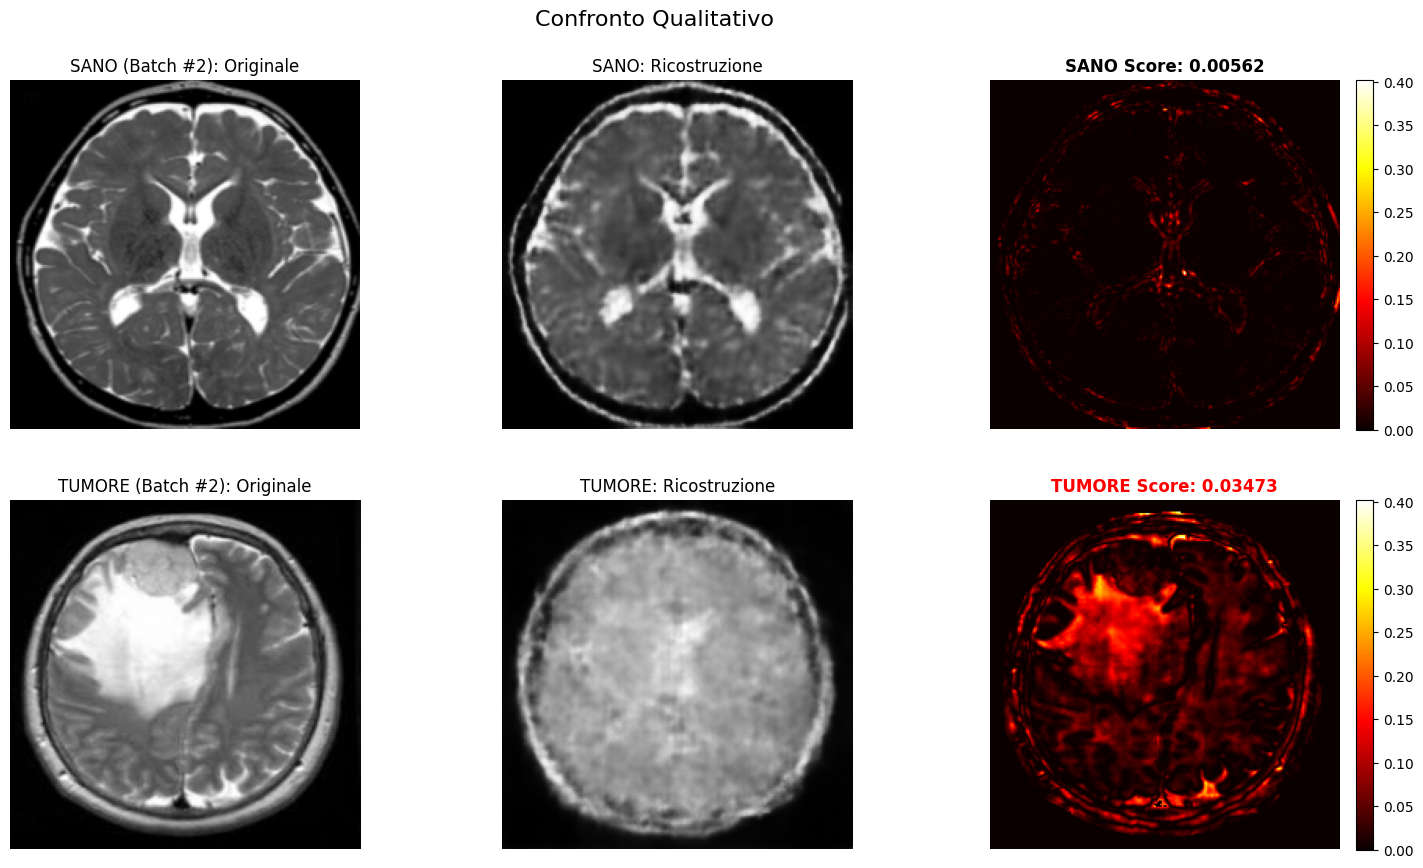

In [ ]:
def visualize_mri_anomaly(model, loader_sani, loader_anno, device, skip_batches=0, skip_sani=None):
    model.eval()
    mse_loss = nn.MSELoss(reduction='none')

    # Se non specifichi skip_sani, usa lo stesso valore di skip_batches
    if skip_sani is None:
        skip_sani = skip_batches

    with torch.no_grad():
        iter_sani = iter(loader_sani)
        iter_anno = iter(loader_anno)

        # Salto i batch per i SANI
        for _ in range(skip_sani):
            try:
                next(iter_sani)
            except StopIteration:
                iter_sani = iter(loader_sani)
                break

        # Salto i batch per i TUMORI
        for _ in range(skip_batches):
            try:
                next(iter_anno)
            except StopIteration:
                iter_anno = iter(loader_anno)
                break

        # Prendo l'immagine corrente
        try:
            img_sano = next(iter_sani)
        except StopIteration:
            iter_sani = iter(loader_sani)
            img_sano = next(iter_sani)

        try:
            img_anno = next(iter_anno)
        except StopIteration:
            iter_anno = iter(loader_anno)
            img_anno = next(iter_anno)

        if isinstance(img_sano, (list, tuple)): img_sano = img_sano[0]
        if isinstance(img_anno, (list, tuple)): img_anno = img_anno[0]

        img_sano = img_sano[0:1].to(device)
        img_anno = img_anno[0:1].to(device)

        rec_sano, _, _ = model(img_sano)
        rec_anno, _, _ = model(img_anno)

        mask_sano = (img_sano > 0.05).float()
        mask_anno = (img_anno > 0.05).float()

        err_sano = mse_loss(rec_sano, img_sano) * mask_sano
        err_anno = mse_loss(rec_anno, img_anno) * mask_anno

        score_sano = err_sano.sum() / (mask_sano.sum() + 1e-8)
        score_anno = err_anno.sum() / (mask_anno.sum() + 1e-8)

        err_sano = err_sano.cpu().squeeze()
        err_anno = err_anno.cpu().squeeze()

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # SANO
        axes[0,0].imshow(img_sano.cpu().squeeze(), cmap='gray')
        axes[0,0].set_title(f"SANO (Batch #{skip_sani}): Originale", fontsize=12)
        axes[0,1].imshow(rec_sano.cpu().squeeze(), cmap='gray')
        axes[0,1].set_title("SANO: Ricostruzione", fontsize=12)
        im1 = axes[0,2].imshow(err_sano, cmap='hot', vmin=0)
        axes[0,2].set_title(f"SANO Score: {score_sano:.5f}", fontsize=12, fontweight='bold')
        fig.colorbar(im1, ax=axes[0,2], fraction=0.046, pad=0.04)

        # TUMORE
        axes[1,0].imshow(img_anno.cpu().squeeze(), cmap='gray')
        axes[1,0].set_title(f"TUMORE (Batch #{skip_batches}): Originale", fontsize=12)
        axes[1,1].imshow(rec_anno.cpu().squeeze(), cmap='gray')
        axes[1,1].set_title("TUMORE: Ricostruzione", fontsize=12)

        vmax_val = max(err_anno.max(), err_sano.max())
        im2 = axes[1,2].imshow(err_anno, cmap='hot', vmin=0, vmax=vmax_val)
        axes[1,2].set_title(f"TUMORE Score: {score_anno:.5f}", fontsize=12, fontweight='bold', color='red')
        fig.colorbar(im2, ax=axes[1,2], fraction=0.046, pad=0.04)

        for ax in axes.flatten(): ax.axis('off')
        plt.suptitle(f"Confronto Qualitativo", fontsize=16, y=0.95)
        plt.show()


visualize_mri_anomaly(model, test_loader_sani, anomaly_loader, device, skip_batches=2, skip_sani=2)
# good visualizations: skip_batches = 3, 19,20,21,22, 27

Analisi FP con Soglia: 0.007980...
 Trovati 33 Falsi Positivi reali su 160 immagini.


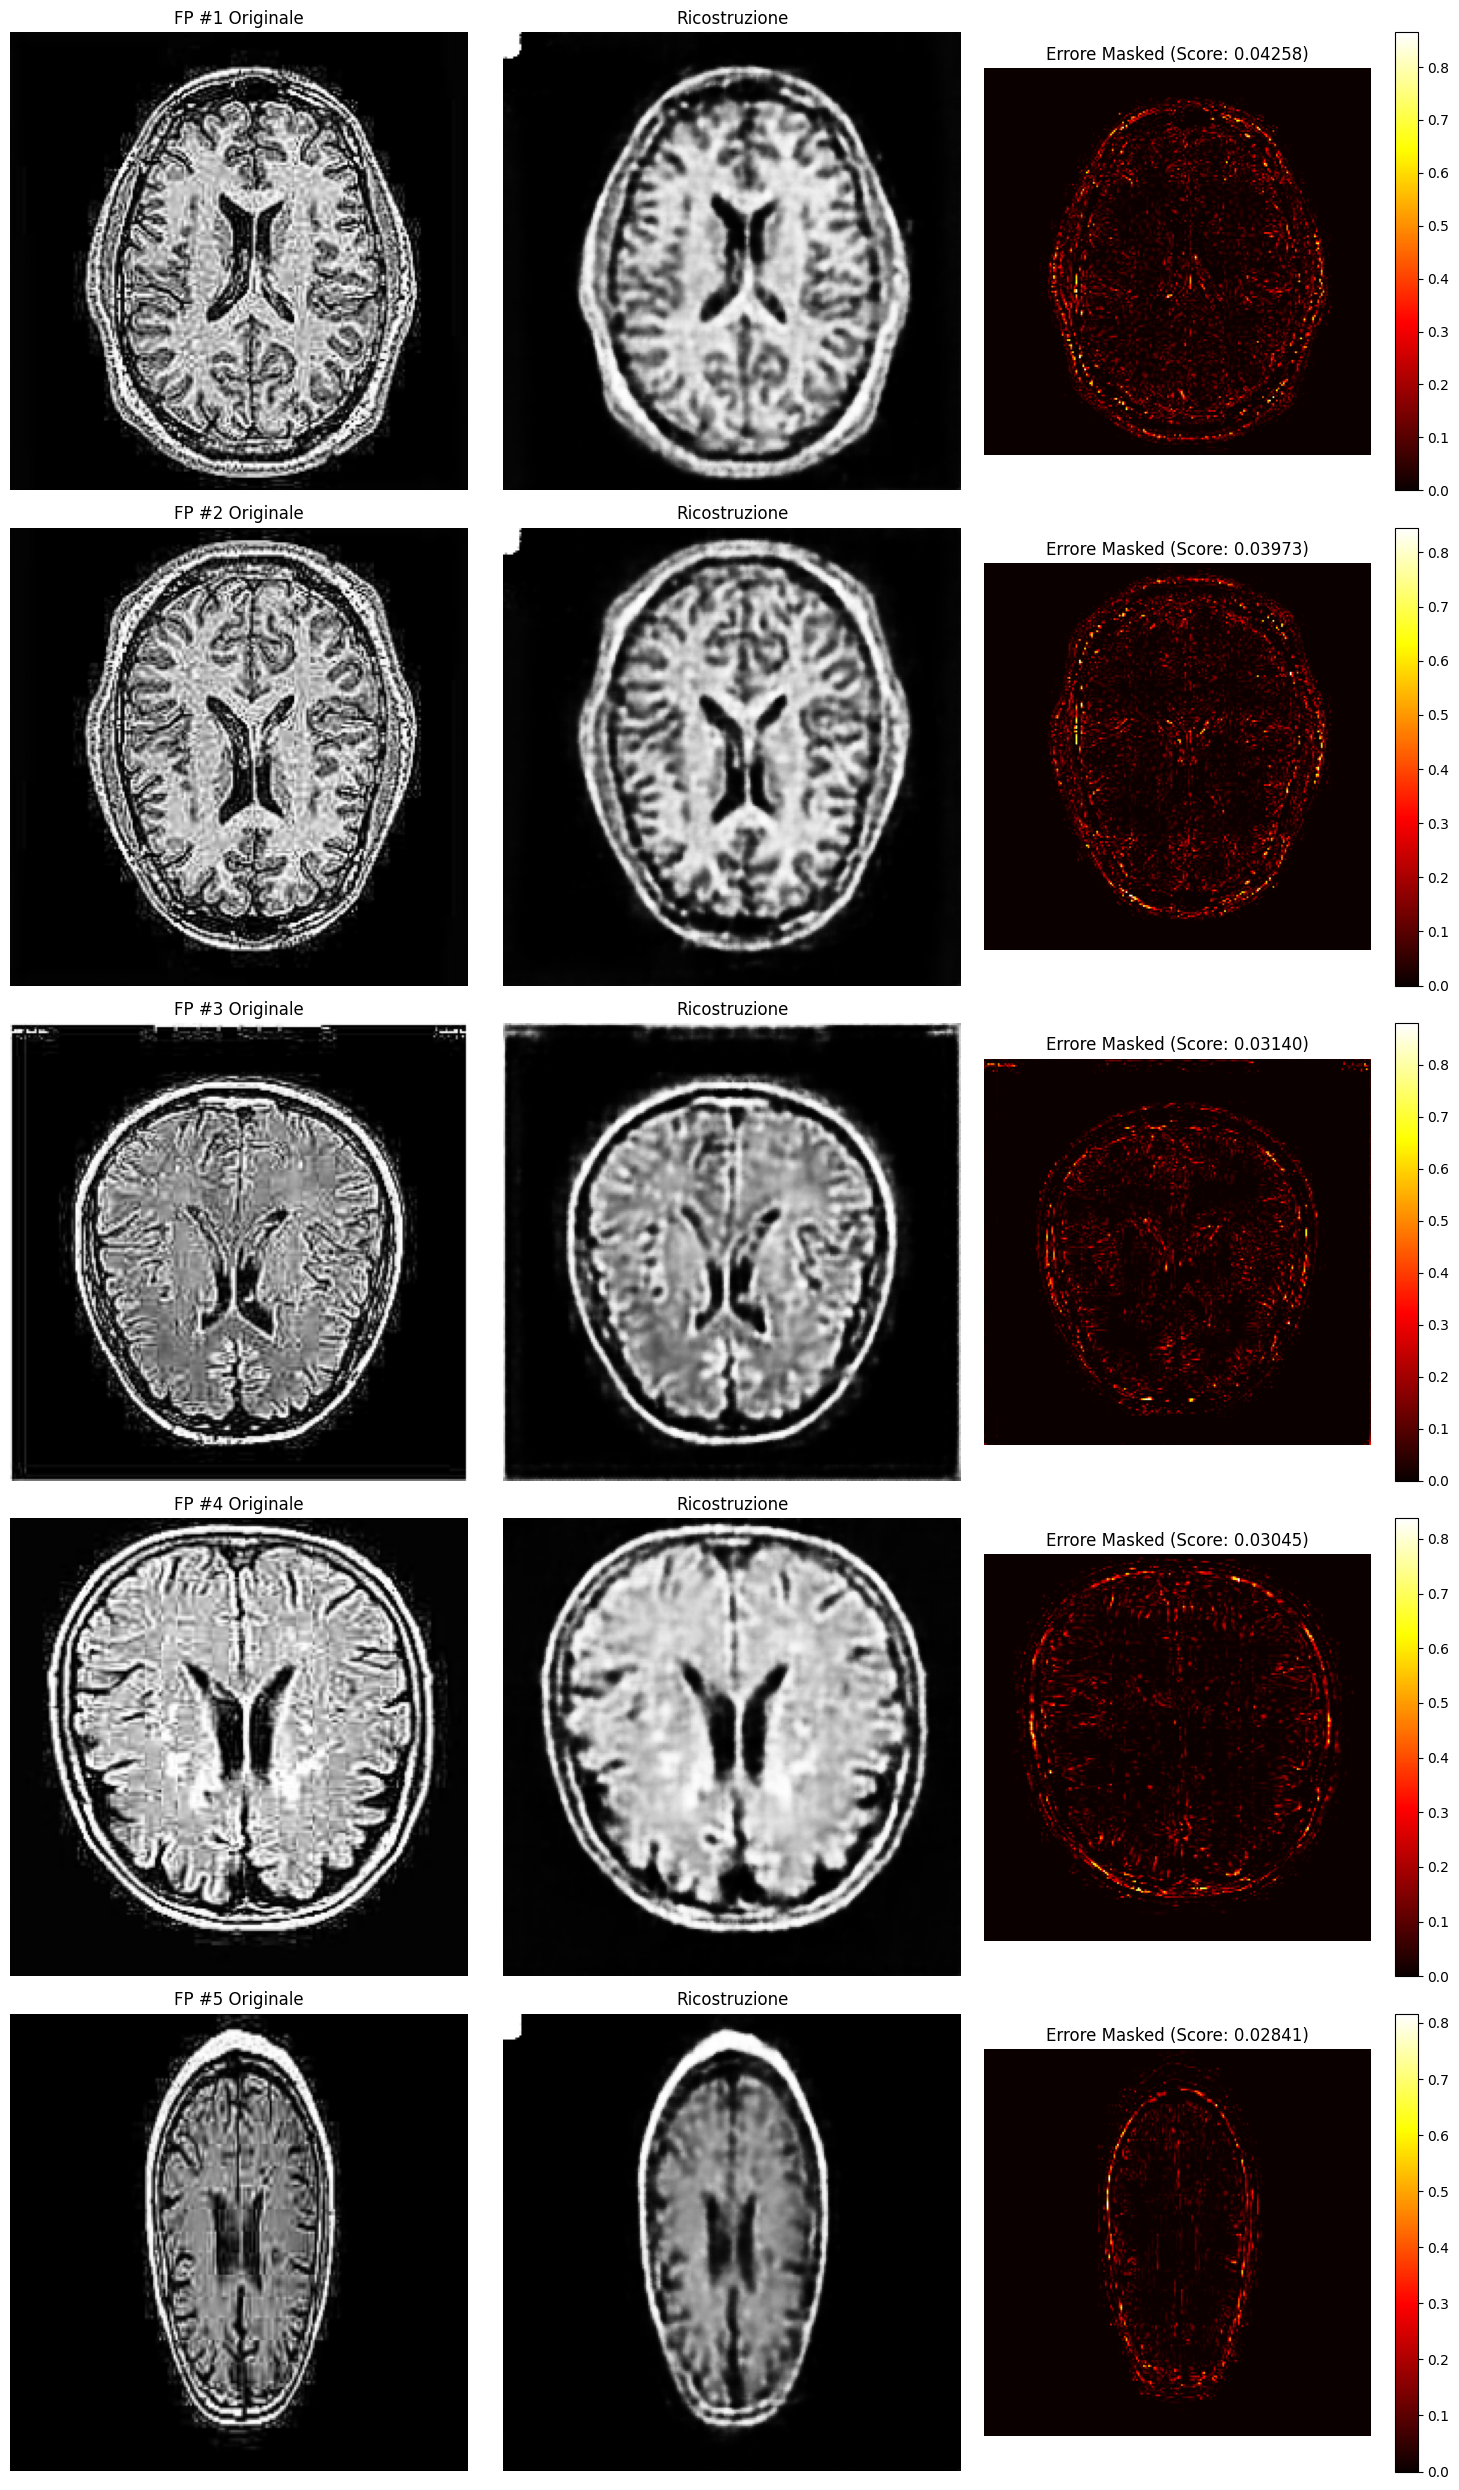

In [ ]:
# identifica immagini sane che il modello ha scambiato per tumori
def analyze_false_positives(model, loader_sani, threshold, device, n_max=5):
    model.eval()
    mse_loss = nn.MSELoss(reduction='none')
    fp_list = []

    print(f"Analisi FP con Soglia: {threshold:.6f}...")

    with torch.no_grad():
        for batch in loader_sani:
            if isinstance(batch, (list, tuple)):
                imgs = batch[0].to(device)
            else:
                imgs = batch.to(device)

            recon, _, _ = model(imgs)

            error_per_pixel = mse_loss(recon, imgs)
            mask = (imgs > 0.05).float()
            masked_error = error_per_pixel * mask

            error_sums = masked_error.view(imgs.size(0), -1).sum(dim=1)
            pixel_counts = mask.view(imgs.size(0), -1).sum(dim=1)
            scores = error_sums / (pixel_counts + 1e-8)
            fp_indices = torch.where(scores > threshold)[0]

            for idx in fp_indices:
                fp_list.append({
                    'img': imgs[idx].cpu(),
                    'rec': recon[idx].cpu(),
                    'err': masked_error[idx].cpu(),
                    'score': scores[idx].item()
                })

    fp_list = sorted(fp_list, key=lambda x: x['score'], reverse=True)

    if not fp_list:
        print(" Ottimo! Nessun Falso Positivo trovato.")
        return

    print(f" Trovati {len(fp_list)} Falsi Positivi reali su {len(loader_sani.dataset)} immagini.")

    # Plotting
    n_plot = min(n_max, len(fp_list))
    fig, axes = plt.subplots(n_plot, 3, figsize=(15, 5 * n_plot))
    if n_plot == 1: axes = [axes] # Gestione singola riga

    for i in range(n_plot):
        img = fp_list[i]['img'].squeeze()
        rec = fp_list[i]['rec'].squeeze()
        err_map = fp_list[i]['err'].squeeze()
        score = fp_list[i]['score']

        axes[i][0].imshow(img, cmap='gray'); axes[i][0].set_title(f"FP #{i+1} Originale")
        axes[i][1].imshow(rec, cmap='gray'); axes[i][1].set_title(f"Ricostruzione")
        im = axes[i][2].imshow(err_map, cmap='hot', vmin=0); axes[i][2].set_title(f"Errore Masked (Score: {score:.5f})")
        fig.colorbar(im, ax=axes[i][2])

        for ax in axes[i]: ax.axis('off')

    plt.tight_layout()
    plt.show()

analyze_false_positives(model, test_loader_sani, optimal_threshold, device)

**Citations**



Loshchilov, I., & Hutter, F. (2017). Decoupled Weight Decay Regularization. arXiv preprint arXiv:1711.05101

Zhou, P., Xie, X., Lin, Z., & Yan, S. (2024). Towards Understanding Convergence and Generalization of AdamW. IEEE Transactions on Pattern Analysis and Machine Intelligence. DOI: 10.1109/TPAMI.2024.10480574.